In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

from utils.Bhushan_utils import *
from utils.Temp_utils import *

%load_ext autoreload
%autoreload 2


/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_25715/2489726230.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Train data read
orig_df = pd.read_csv(r"./dataset/train.csv")
test_df = pd.read_csv(r"./dataset/test.csv")
print(len(orig_df), len(test_df))
print(orig_df['depreciation'].isnull().sum(), orig_df['coe'].isnull().sum(), orig_df['transmission'].isnull().sum())

25000 10000
507 0 0


In [3]:
train_df, val_df = train_test_split(orig_df, test_size=0.2, random_state=42, shuffle=True)
print(len(train_df), len(val_df))

20000 5000


In [11]:
# Make model Imputation - No need to merge to main

unique_makes = orig_df['make'].unique()
unique_makes_list = sorted([make for make in unique_makes if pd.notnull(make)])
makes_regex = compile_make_pattern(unique_makes_list)
train_df = apply_make_extraction(train_df, makes_regex)
val_df = apply_make_extraction(val_df, makes_regex)

In [4]:
# Impute manufactured date
train_df = impute_manufactured_date(train_df) 
val_df = impute_manufactured_date(val_df) 

In [25]:
depreciation_imputer = DepreciationImputer()

In [34]:
# Vehicle Age - Added car_age feature to be used for depreciation imputation - Dependency on 'manufactured'
# Manufactured == Reg Year 
train_df = depreciation_imputer.calc_vehicle_age(train_df) # 0 empty records - due to 'manufactured' having 7 empty records
val_df = depreciation_imputer.calc_vehicle_age(val_df) # 0 empty records

In [6]:
# Depreciation

# Used for checking sanity
train_df['depreciation_og'] = train_df['depreciation']

# Imputation using make, model and car age - Dependency on 'car_age'
depreciation_imputer = DepreciationImputer()
train_df = depreciation_imputer.fit_transform(train_df) # 96 empty records
val_df = depreciation_imputer.transform(val_df) # 9 empty records

# Median imputation for remaining records
imputer = SimpleImputer(strategy='median')
train_df['depreciation'] = imputer.fit_transform(train_df[['depreciation']])
val_df['depreciation'] = imputer.transform(val_df[['depreciation']])
test_df['depreciation'] = imputer.transform(test_df[['depreciation']])

In [6]:
# Transmission

# One-hot (Binary) encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
train_df['transmission'] = encoder.fit_transform(train_df[['transmission']])
val_df['transmission'] = encoder.transform(val_df[['transmission']])

In [8]:
# COE

# Cap Outliers - Dependency on 'engine_cap' and 'type_of_vehicle'
train_df = cap_coe_outliers(train_df)
val_df = cap_coe_outliers(val_df)


Depreciation Sanity Check

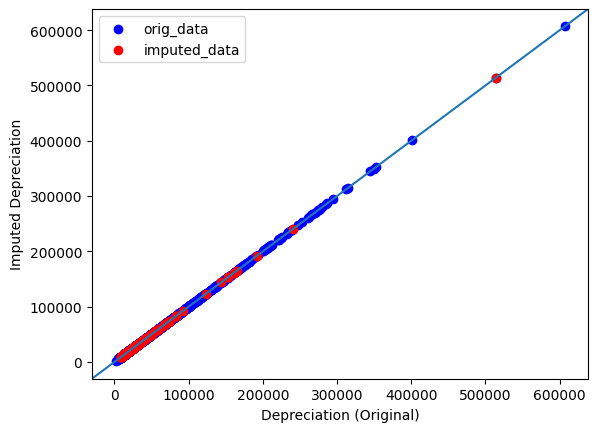

In [9]:
train_df['depreciation_impute'] = train_df['depreciation']
train_df['depreciation_fillna'] = train_df['depreciation_og'].fillna(train_df['depreciation_impute'])

plt.scatter(train_df['depreciation_og'], train_df['depreciation_impute'], color='b')
plt.scatter(
    train_df[train_df['depreciation_og'].isna()]['depreciation_fillna'],
    train_df[train_df['depreciation_og'].isna()]['depreciation_impute'],
    color='r'
)
plt.legend(['orig_data', 'imputed_data'])
plt.xlabel("Depreciation (Original)")
plt.ylabel("Imputed Depreciation")
plt.axline((0, 0), slope=1)
plt.show()